In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import os
import json

### Load in the data

In [3]:
df = pd.read_csv('data/data_random_split.csv')

In [4]:
df.head()

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID,split
0,palestine,Breitbart News,2,http://www.breitbart.com/big-journalism/2015/0...,"Obama, Media Lied About Netanyahu and the Pale...",2015-03-20,Ben Shapiro,"For the last several days , the entire Western...","For the last several days, the entire Western ...",www.breitbart.com,right,uI2K5BSCO0LaWuKb,test
1,federal_budget,ABC News,0,http://abcnews.go.com/blogs/politics/2013/03/w...,Will Fractured House Republicans Unite on Budget?,NaN,John Parkinson,"Tomorrow morning , House Budget Chairman Paul ...","Jacquelyn Martin/AP Photo\n\nTomorrow morning,...",www.abcnews.go.com,left,zeSfcxLilzR0R1Dt,test
2,fbi,Reuters,1,https://www.reuters.com/article/us-usa-trump-r...,Trump blocks release of Russia memo drafted by...,2018-02-10,Ayesha Rascoe,WASHINGTON ( ███ ) - President Donald Trump on...,WASHINGTON (Reuters) - President Donald Trump ...,www.reuters.com,center,ru8kAxfdPzZc11le,test
3,politics,CBN,2,http://www1.cbn.com/cbnnews/politics/2019/febr...,Trump's North Korea Peace Talks Share Spotligh...,2019-02-25,NaN,"President Donald Trump arrives in Hanoi , Viet...","President Donald Trump arrives in Hanoi, Vietn...",www1.cbn.com,right,TTt5FFmsW6ng3fsC,test
4,media_bias,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Six Times President Trump Upset Jared Kushner ...,2017-08-20,Adam Shaw,President Trump ’ s fiery response to the even...,President Trump’s fiery response to the events...,www.breitbart.com,right,gYKaZGjLCYdEghTZ,test


The dataset has already been cleaned and preprocessed as in the content column.

In [5]:
df.columns

Index(['topic', 'source', 'bias', 'url', 'title', 'date', 'authors', 'content',
       'content_original', 'source_url', 'bias_text', 'ID', 'split'],
      dtype='object')

In [6]:
#check missing values in the dataset
df.isnull().sum()

topic                  0
source                 0
bias                   0
url                    0
title                  0
date                4039
authors             9262
content                0
content_original       0
source_url             0
bias_text              0
ID                     0
split                  0
dtype: int64

### EDA

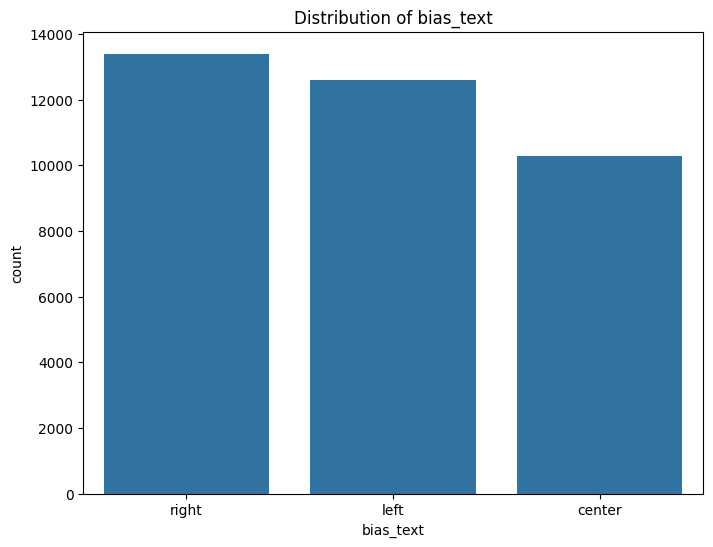

In [7]:
# plot the distribution of bias_text
plt.figure(figsize=(8, 6))
sns.countplot(x='bias_text', data=df)
plt.title('Distribution of bias_text')
plt.show()

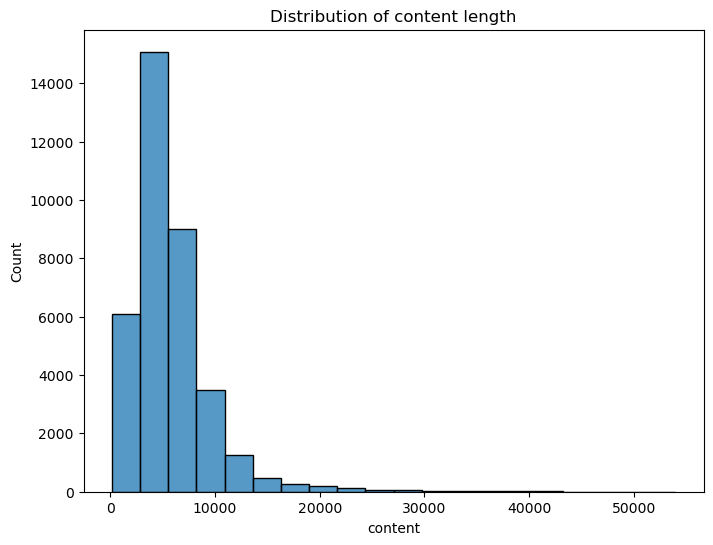

In [8]:
# plot the distribution of content length
plt.figure(figsize=(8, 6))
sns.histplot(df['content'].str.len(), bins=20)
plt.title('Distribution of content length')
plt.show()

### Word Clouds for Each Bias

In [15]:
# Remove stopwords
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english')) | set(("said", "s"))

def remove_stopwords(text):
    word_tokens = text.split()
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

df['cloud_text'] = df['content_original'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dotin13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


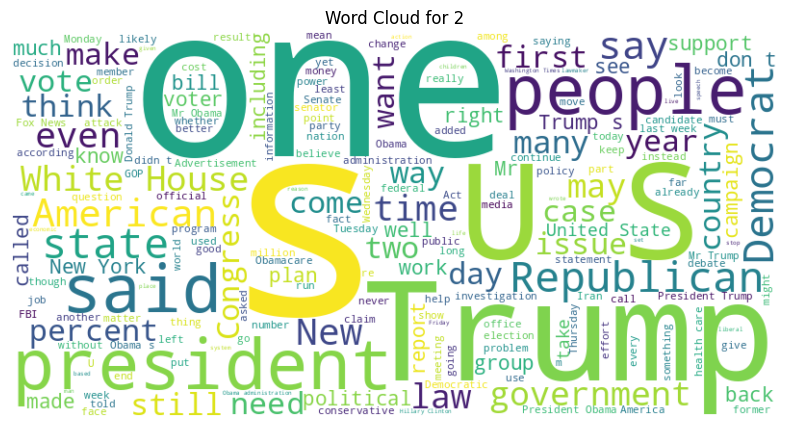

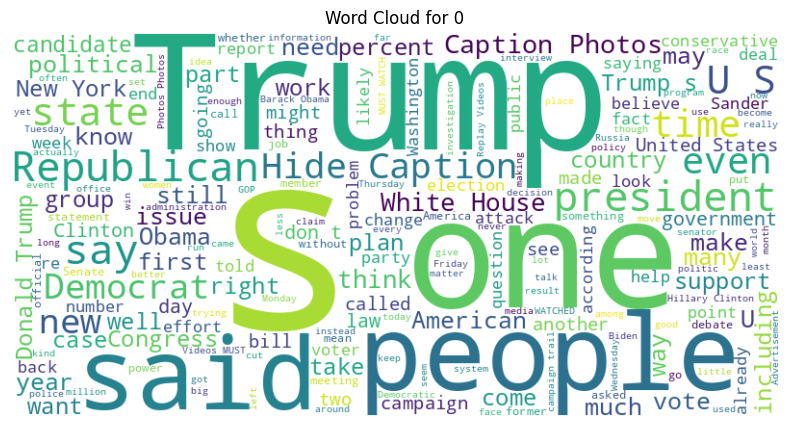

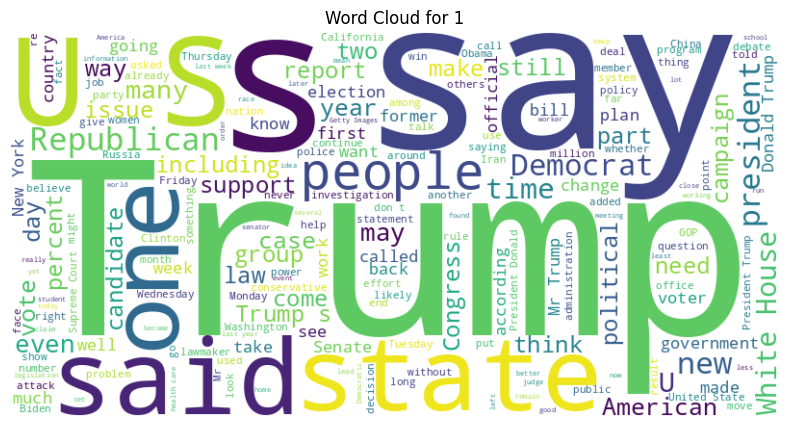

In [16]:
# !pip install wordcloud
from wordcloud import WordCloud

biases = df['bias'].unique()
for bias in biases:
    # Sample 1% of the data
    df_sample = df[df['bias'] == bias].sample(frac=0.1)
    text = ' '.join(df_sample['cloud_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {bias}")
    plt.axis('off')
    plt.show()

### Text Preprocessing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from tqdm import tqdm

def tokenize_and_tfidf(df, text_column='content'):
    """
    Tokenizes text using a Transformer tokenizer and applies TF-IDF vectorization.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a column with text data.
    - text_column (str): Column name that contains raw text.
    - model_name (str): Hugging Face model to use for tokenization.

    Returns:
    - tfidf_matrix (sparse matrix): TF-IDF transformed matrix of tokenized text.
    - feature_names (list): List of TF-IDF feature names (tokens).
    """

    # Enable progress bar
    tqdm.pandas()

    # Apply TF-IDF and remove stopwords with automatic tokenizer
    tfidf = TfidfVectorizer(stop_words='english', max_features=3000, min_df=5)
    tfidf_matrix = tfidf.fit_transform(df[text_column])

    return tfidf_matrix, tfidf.get_feature_names_out()

In [20]:
# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='content')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Display sample feature names (tokens)
print("Sample Tokens:", feature_names[:10])

TF-IDF Matrix Shape: (36274, 3000)
Sample Tokens: ['000' '01' '02' '10' '100' '11' '12' '13' '14' '15']


In [21]:
# convert the matrix to a pandas DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.head()

,000,01,02,10,100,11,12,13,14,15,...,year,years,yemen,yes,yesterday,york,young,younger,zero,zone
0,0.0,0.0,0.0,0.019985,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.028465,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.019982,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052740,0.014230,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.020961,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013831,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025154,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.087467,0.0,0.0,0.0,0.0


In [22]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# remove numeric tokens in tfidf_df
def remove_numeric_tokens(text):
    return " ".join([word for word in text.split() if not re.fullmatch(r"\d+", word)])

# Apply the function to the 'content' column
df['clean_text'] = df['content'].apply(remove_numeric_tokens)

# Run Tokenization and TF-IDF
tfidf_matrix, feature_names = tokenize_and_tfidf(df, text_column='clean_text')

# Check the shape of the matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (36274, 3000)


In [23]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.head()

,000,01,02,10,100,11,12,13,15,16,...,year,years,yemen,yes,yesterday,york,young,younger,zero,zone
0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.028493,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.052978,0.014294,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.03119,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013831,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025225,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.087886,0.0,0.0,0.0,0.0


### Top N frequent words for each bias

In [24]:
# For each bias, get the top 10 words by average TF-IDF score
for bias in biases:
    mean_tfidf = tfidf_df[df['bias'] == bias].mean().drop('bias')
    top_words = mean_tfidf.sort_values(ascending=False).head(10)
    print(f"Top words for bias '{bias}':")
    print(top_words, "\n")

Top words for bias '2':
trump        0.064248
said         0.058229
mr           0.049287
president    0.040600
obama        0.037367
house        0.028516
clinton      0.026163
people       0.026068
percent      0.025444
state        0.023815
dtype: float64 

Top words for bias '0':
trump        0.068833
said         0.059145
obama        0.037310
president    0.035066
clinton      0.029868
people       0.029843
house        0.029615
mr           0.028256
campaign     0.025520
new          0.025287
dtype: float64 

Top words for bias '1':
trump        0.090170
said         0.066865
president    0.040208
mr           0.032708
says         0.032327
house        0.032123
people       0.026684
democrats    0.024989
new          0.024437
state        0.024322
dtype: float64 



## Model Training

### Tree-Based Model

In [25]:
df["split"].value_counts()

split
train    27978
valid     6996
test      1300
Name: count, dtype: int64

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Convert TF-IDF matrix to array
X = tfidf_matrix.toarray()
y = df['bias']

X_train = X[df["split"] == "train"]
y_train = y[df["split"] == "train"]
X_val = X[df["split"] == "valid"]
y_val = y[df["split"] == "valid"]
X_test = X[df["split"] == "test"]
y_test = y[df["split"] == "test"]

In [27]:
print("Training Set Shape:", X_train.shape, y_train.shape)

Training Set Shape: (27978, 3000) (27978,)


In [36]:
# Train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Predict on test set
y_pred = rf_clf.predict(X_val)

# Evaluate model performance
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

Random Forest Accuracy: 0.6972555746140652
Classification Report:
               precision    recall  f1-score   support

        left       0.76      0.63      0.69      2438
      center       0.83      0.57      0.67      1998
       right       0.61      0.87      0.72      2560

    accuracy                           0.70      6996
   macro avg       0.74      0.69      0.69      6996
weighted avg       0.73      0.70      0.69      6996



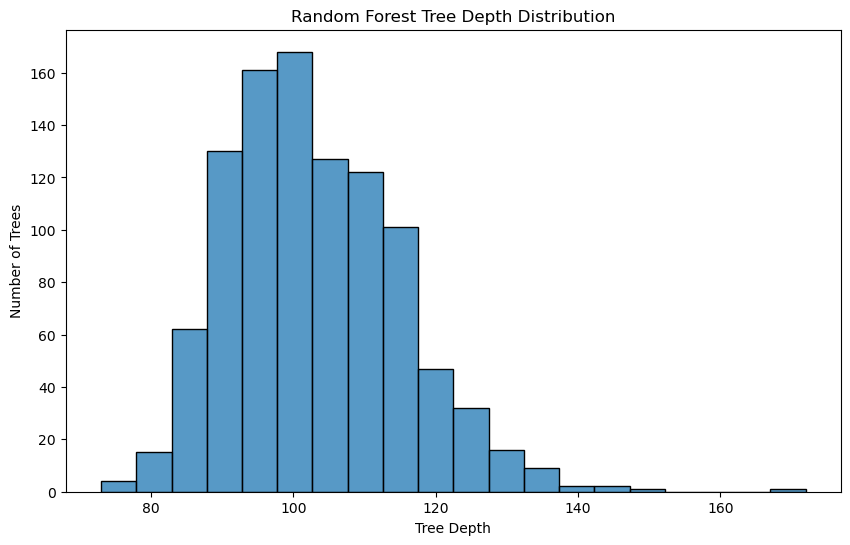

In [42]:
# Visualize the depth of the trees
plt.figure(figsize=(10, 6))
sns.histplot([estimator.tree_.max_depth for estimator in rf_clf.estimators_], bins=20)
plt.title('Random Forest Tree Depth Distribution')
plt.xlabel('Tree Depth')
plt.ylabel('Number of Trees')
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter for RandomizedSearch
param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Number of trees
    'max_depth': [30, 50, 100, 125, 150],     # Depth of trees
    'min_samples_split': [2, 5, 10]   # Minimum samples per split
}

# Run RandomizedSearch
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, verbose=2, n_iter=15)
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Train final model with best params
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_val)

# Evaluate tuned model
print("Tuned Random Forest Accuracy:", accuracy_score(y_val, y_pred_best))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END max_depth=125, min_samples_split=10, n_estimators=100; total time=   4.0s
[CV] END max_depth=125, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END max_depth=125, min_samples_split=10, n_estimators=100; total time=   3.7s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  36.9s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  35.0s
[CV] END max_depth=125, min_samples_split=2, n_estimators=1000; total time=  35.6s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   8.9s
[CV] END max_depth=30, min_samples_split=5, n_estimators=300; total time=   8.9s
[CV] END max_depth=30, min_sample

In [38]:
print(classification_report(y_val, y_pred_best, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.77      0.59      0.67      2438
      center       0.85      0.55      0.67      1998
       right       0.59      0.88      0.71      2560

    accuracy                           0.69      6996
   macro avg       0.74      0.68      0.68      6996
weighted avg       0.73      0.69      0.68      6996



### PCA

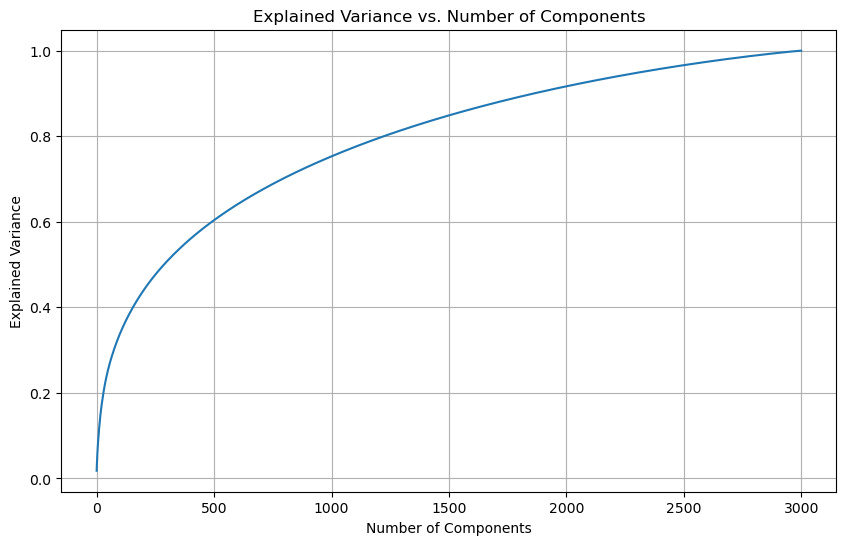

In [23]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Initialize PCA with 2 components
pca = PCA(n_components=3000)
X_pca = pca.fit_transform(X)    # Fit and transform the data


# Plot explained variance to find the best n_components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


In [27]:
# Apply PCA with optimal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2000)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# #save pca results
# np.save('X_train_pca.npy', X_train_pca)
# np.save('X_test_pca.npy', X_test_pca)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest on PCA-reduced features
rf_clf_pca = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_clf_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = rf_clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
classification_report_pca = classification_report(y_test, y_pred_pca, target_names=['left', 'center', 'right'])

print("Random Forest Accuracy after PCA:", accuracy_pca)
print("Classification Report:\n", classification_report_pca)

Random Forest Accuracy after PCA: 0.4642524297696711
Classification Report:
               precision    recall  f1-score   support

        left       0.47      0.47      0.47      2629
      center       0.59      0.13      0.21      2103
       right       0.45      0.71      0.55      2779

    accuracy                           0.46      7511
   macro avg       0.50      0.44      0.41      7511
weighted avg       0.50      0.46      0.43      7511



In [ ]:
# logreg on PCA reduced features
from sklearn.linear_model import LogisticRegression
logreg_pca = LogisticRegression(max_iter=1000)
logreg_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_logreg_pca = logreg_pca.predict(X_test_pca)
accuracy_logreg_pca = accuracy_score(y_test, y_pred_logreg_pca)
classification_report_logreg_pca = classification_report(y_test, y_pred_logreg_pca, target_names=['left', 'center', 'right'])

In [ ]:
print(classification_report_logreg_pca)

              precision    recall  f1-score   support

        left       0.60      0.57      0.59       402
      center       0.58      0.74      0.65       299
       right       0.70      0.62      0.66       599

    accuracy                           0.64      1300
   macro avg       0.63      0.65      0.63      1300
weighted avg       0.64      0.64      0.64      1300



### Model 2: Logistic Regression

In [17]:
# # load in the pca results
# X_train_pca = np.load('X_train_pca.npy')
# X_test_pca = np.load('X_test_pca.npy')

y = df['bias']

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter

In [19]:
y = df['bias']
Counter(y)

Counter({2: 13399, 0: 12590, 1: 10285})

In [20]:
# a baseline logistic regression model
baseline_clf = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
baseline_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

In [21]:
y_pred_baseline = baseline_clf.predict(X_val)

In [22]:
# baseline logreg evaluation
print(classification_report(y_val, y_pred_baseline, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.69      0.67      0.68      2438
      center       0.70      0.65      0.68      1998
       right       0.66      0.72      0.69      2560

    accuracy                           0.68      6996
   macro avg       0.69      0.68      0.68      6996
weighted avg       0.69      0.68      0.68      6996



In [ ]:
# Logistic Regression and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# random search for best hyperparameters
param_rand = {
    'C': [0.1, 0.5, 1, 10, 100],
    'penalty':('l1', 'l2')
}

rand_search = RandomizedSearchCV(LogisticRegression(random_state=42, solver="saga", max_iter=1000, n_jobs=-1), 
                                 param_rand,cv=2, verbose=2, n_iter=10, n_jobs=-1)
rand_search.fit(X_train, y_train)

print("Best Parameters from Random Search:", rand_search.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END ..................................C=0.1, penalty=l2; total time=  32.1s
[CV] END ..................................C=0.1, penalty=l2; total time=  32.6s
[CV] END ..................................C=0.1, penalty=l1; total time=  46.1s
[CV] END ....................................C=1, penalty=l2; total time=  30.0s
[CV] END ..................................C=0.1, penalty=l1; total time= 1.5min
[CV] END ....................................C=1, penalty=l2; total time=  29.2s
[CV] END ....................................C=1, penalty=l1; total time= 3.4min
[CV] END ....................................C=1, penalty=l1; total time= 4.0min
[CV] END ..................................C=100, penalty=l2; total time= 4.7min
[CV] END ..................................C=100, penalty=l2; total time= 4.8min
[CV] END ...................................C=10, penalty=l2; total time= 1.0min
[CV] END ..................................C=0.5

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=22.8min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=22.9min
Best Parameters from Random Search: {'penalty': 'l1', 'C': 1}


In [24]:
# evalue the tuned model on the test set
best_logreg = rand_search.best_estimator_
y_pred_logreg = best_logreg.predict(X_val)

In [25]:
# logreg evaluation
print(classification_report(y_val, y_pred_logreg, target_names=['left', 'center', 'right']))

              precision    recall  f1-score   support

        left       0.70      0.67      0.69      2438
      center       0.71      0.66      0.69      1998
       right       0.67      0.73      0.70      2560

    accuracy                           0.69      6996
   macro avg       0.69      0.69      0.69      6996
weighted avg       0.69      0.69      0.69      6996



In [26]:
# logreg feature coefficients
best_logreg.coef_

array([[ 0.        ,  0.        ,  0.        , ...,  1.5070389 ,
         0.18684395,  0.61668808],
       [ 0.        ,  0.        ,  0.        , ..., -0.39021404,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.30539079]])

In [ ]:
# confusion matrix for logreg
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=bias, yticklabels=bias)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

/var/folders/g8/djv8qmmn3_q5xx0wytt877jw0000gn/T/ipykernel_22431/3490295033.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


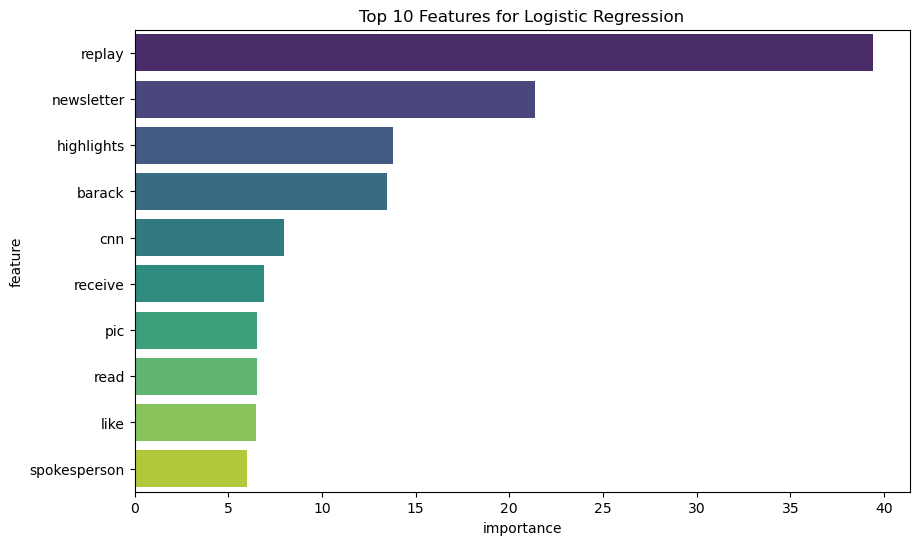

In [28]:
# feature importance for the best logreg model
coef = best_logreg.coef_[0]
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': coef})
top_features = feature_importance.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 10 Features for Logistic Regression')
plt.show()

### Boosting

In [ ]:
# ensemble method: boosting of random forest and logistic regression
from sklearn.ensemble import AdaBoostClassifier

xgb_clf = AdaBoostClassifier(n_estimators=1000, learning_rate=0.05, algorithm="SAMME", random_state=42)
xgb_clf.fit(X_train, y_train)

In [ ]:
y_pred_xgb = xgb_clf.predict(X_val)

In [ ]:
# boosting evaluation
report = classification_report(y_val, y_pred_xgb, target_names=['left', 'center', 'right'])
print(report)

### Stacking

In [26]:
from sklearn.ensemble import StackingClassifier

estimators = [('rf', best_rf), ('logreg', best_logreg)]
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=LogisticRegression(random_state=42, n_jobs=-1, solver="saga", max_iter=1000), 
                                  n_jobs=-1)

stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=125,
                                                       min_samples_split=10,
                                                       n_estimators=1000,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('logreg',
                                LogisticRegression(C=1, max_iter=1000,
                                                   n_jobs=-1, penalty='l1',
                                                   random_state=42,
                                                   solver='saga'))],
                   final_estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                      random_state=42,
                                                      solver='saga'),
                   n_jobs=-1)

In [27]:
# predict and evaluate
y_pred_stacking = stacking_clf.predict(X_val)
report_stacking = classification_report(y_val, y_pred_stacking, target_names=['left', 'center', 'right'])
print(report_stacking)

              precision    recall  f1-score   support

        left       0.74      0.71      0.72      2438
      center       0.75      0.70      0.72      1998
       right       0.70      0.76      0.73      2560

    accuracy                           0.72      6996
   macro avg       0.73      0.72      0.72      6996
weighted avg       0.73      0.72      0.72      6996



In [22]:
# logistic regression on embedded features
embeddings = np.load('data/embeddings.npy')

In [ ]:
y = df['bias']

In [29]:
train_mask = df['split'] == 'train'
test_mask = df['split'] == 'test'

# Split the embeddings and the outcome into training and testing sets
X_train = embeddings[train_mask]
X_test = embeddings[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

In [31]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42, solver='saga', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='saga')

In [32]:
# predict and evalaute
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['left', 'center', 'right'])
print(report)

              precision    recall  f1-score   support

        left       0.32      0.40      0.36       402
      center       0.20      0.04      0.06       299
       right       0.46      0.58      0.52       599

    accuracy                           0.40      1300
   macro avg       0.33      0.34      0.31      1300
weighted avg       0.36      0.40      0.36      1300

